In [9]:
import pandas as pd
import numpy as np

# import eruption data 
databaseRAW = pd.read_excel(r'GVP_1900_Jan21_2021.xlsx')


In [10]:
cut_off_database = 2000
# 1980 is what Byrne & Krishnamoorthy (2022) use 
# 1960 is the value which seems to be an equally good cut-off point considering the fraction 
# of VEI according to Figure 1 in Byrne & Krishnamoorthy (2022)
# 1955 is the year from which we can use the database as the start dates for each eruption are complete by that point

# make raw database into array 
database0 = pd.DataFrame(databaseRAW).to_numpy()

# select correct time period database
database1 = database0[database0[:,5]>=cut_off_database, :]

# remove all the entries for which we do not have a VEI 
database2 = database1[~pd.isnull(database1[:,4]), :]

print(database2.shape)

(749, 13)


In [11]:
# prepare database

import datetime as dt 

which_database = 2
# 1 = short tail database 
# 2 = long tail database  

counter_no_end_date = 0

counter  = 0 
index    = np.empty(len(database2))
index[:] = np.nan

database = database2

if   (which_database == 1):
    maximum_eruption_duration = 100  #days 
elif (which_database == 2):
    maximum_eruption_duration = 1000 #days 

for i in range(0,len(database)):
    
    if np.isnan(database[i,8]): 
        # if there is no end date, the eruption is still going, so set the end date to the end of the database date
        database[i,8]      = 2021
        database[i,9]      = 1
        database[i,10]     = 21
        counter_no_end_date = counter_no_end_date + 1
    elif np.isnan(database[i,9]):
        database[i,9]      = database[i,6]
        database[i,10]     = database[i,7]
        counter_no_end_date = counter_no_end_date + 1
    elif np.isnan(database[i,10]):
        database[i,10]     = database[i,7]
        counter_no_end_date = counter_no_end_date + 1
    
    start_date = dt.date(int(database[i,5]),int(database[i,6]),int(database[i,7]))
    end_date   = dt.date(int(database[i,8]),int(database[i,9]),int(database[i,10]))
    
    eruption_duration = end_date - start_date
    
    if (eruption_duration.days > maximum_eruption_duration):      
        new_end_date   = start_date + dt.timedelta(days=maximum_eruption_duration-1)
        database[i,8]  = new_end_date.year
        database[i,9]  = new_end_date.month
        database[i,10] = new_end_date.day
        
final_Earth_database   = database

print(final_Earth_database.shape)

(749, 13)


In [12]:
import pandas as pd

# import volcano classification --> update to correct file path! 
classification_volcanoesRAW = pd.read_excel(r'GVP_Classified1955.xlsx')

classification_volcanoes = pd.DataFrame(classification_volcanoesRAW).to_numpy()

print(classification_volcanoes.shape)


(337, 6)


In [13]:
# classify the eruptions in the database according to geodynamic setting
# 1 - continental intraplate 
# 2 - rift zone 
# 3 - oceanic intraplate 
# 4 - subduction zone 

unclassified_volcanoes    = np.empty(len(final_Earth_database))
unclassified_volcanoes[:] = np.nan

counter = 0
for i in range(0,len(final_Earth_database)):
    check = 0 
    for j in range(0,len(classification_volcanoes)):
        if (final_Earth_database[i,0] == classification_volcanoes[j,1]):
            final_Earth_database[i,3] = classification_volcanoes[j,5] 
            check = 1 
    if (check == 0):
        # the volcano is not classified yet
        double_volcano = final_Earth_database[i,0] in unclassified_volcanoes
        if (double_volcano == False):
            unclassified_volcanoes[counter] = final_Earth_database[i,0]
            print(unclassified_volcanoes[counter])
            counter = counter + 1
            
# how many eruptions do we have of each class?
amount_continental_intraplate_eruptions = np.count_nonzero(final_Earth_database[:,3]==1)
amount_rift_zone_eruptions              = np.count_nonzero(final_Earth_database[:,3]==2)
amount_oceanic_intraplate_eruptions     = np.count_nonzero(final_Earth_database[:,3]==3)
amount_subduction_zone_eruptions        = np.count_nonzero(final_Earth_database[:,3]==4)

unclassified_volcanoes = unclassified_volcanoes[~np.isnan(unclassified_volcanoes)]

print('Number of continental intraplate eruptions: ',amount_continental_intraplate_eruptions)
print('Number of rift zone eruptions:              ',amount_rift_zone_eruptions)
print('Number of oceanic intraplate eruptions:     ',amount_oceanic_intraplate_eruptions)
print('Number of subduction zone eruptions:        ',amount_subduction_zone_eruptions)
print(' ')
print('Number of unclassified volcanoes:           ',counter)
            

Number of continental intraplate eruptions:  1
Number of rift zone eruptions:               30
Number of oceanic intraplate eruptions:      51
Number of subduction zone eruptions:         667
 
Number of unclassified volcanoes:            0


In [14]:
import numpy as np
import random 

# bootstrapping 

# which eruptions? 
which_eruptions    = 1
# 1 = new & ongoing eruptions 
# 2 = new eruptions 

# which planet scaling? 
scaling      = 1
# 0 = Earth 
# 1 = Venus -> 0.736 from B&K 2022
# 2 = Mars 
# 3 = Moon 
# 4 = Mercury 
# 5 = Venus with subduction scaling 

time_window        = 365 #days 
number_of_trials   = 100000

bootstrapped_data  = np.zeros((number_of_trials,7))

start_database     = dt.date(cut_off_database, 1, 1)
end_database       = dt.date(2021, 1, 21) - dt.timedelta(days=time_window)
    
days_between_dates = (end_database - start_database).days

if   (scaling == 0):
    # Earth 
    scaling_factor = 1 
elif (scaling == 1):
    # Venus -> 0.736 from B&K 2022
    scaling_factor = 0.902 * 0.816 
elif (scaling == 2):
    # Mars 
    scaling_factor = 0.284 * 0.107
elif (scaling == 3):
    # Moon 
    scaling_factor = 0.074 * 0.0123
elif (scaling == 4):
    # Mercury 
    scaling_factor = 0.147 * 0.055
elif (scaling == 5):
    # Venus with subduction scaling 
    subduction_scaling = 10000 / 51310 
    scaling_factor     = 0.902 * 0.816

scaled_number_of_events = int(scaling_factor * len(final_Earth_database))
print(scaled_number_of_events)

551


In [15]:
for i in range(0,number_of_trials):
    
    # select random Venus database 
    if   (scaling == 0):
        bootstrap_database = final_Earth_database 
    elif (scaling >  0):
        random_entries_database = np.sort(np.array(random.sample(range(0, len(final_Earth_database)), scaled_number_of_events)))
        bootstrap_database = final_Earth_database[random_entries_database,:]
    
    if (scaling == 5):
        #print(bootstrap_database.shape)
    
        # apply subduction scaling if required 
        check_subduction_index      = np.where(bootstrap_database[:,3] == 4)
        subduction_indices          = check_subduction_index[0]
        number_of_subduction_events = len(subduction_indices)
        subduction_indices_list     = subduction_indices.tolist()
        
        # select volcanic eruptions to delete from database 
        delete_subduction_eruptions = np.array(random.sample(subduction_indices_list, int((1-subduction_scaling)*number_of_subduction_events)))
        
        #print(bootstrap_database.shape)
        
        # delete excess subduction zone related volcanism from bootstrap database 
        bootstrap_database = np.delete(bootstrap_database, delete_subduction_eruptions, 0)
        
        #print(check_subduction_index)
        #print(subduction_indices)
        #print(number_of_subduction_events)
        #print(test)
        #print(test.shape,int((1-subduction_scaling)*number_of_subduction_events))
        #print(bootstrap_database.shape)
     
    # select random 60-day window for observation
    random_number_of_days = random.randrange(days_between_dates)
    
    start_date_window     = start_database + dt.timedelta(days=random_number_of_days)
    end_date_window       = start_date_window + dt.timedelta(days=time_window-1)
    
    for k in range(0,len(bootstrap_database)):
        
        start_date_eruption = dt.date(int(bootstrap_database[k,5]),int(bootstrap_database[k,6]),int(bootstrap_database[k,7]))
        end_date_eruption   = dt.date(int(bootstrap_database[k,8]),int(bootstrap_database[k,9]),int(bootstrap_database[k,10]))
        
        if   (which_eruptions == 1):
            if ((start_date_eruption >= start_date_window and start_date_eruption <= end_date_window) or ( end_date_eruption >= start_date_window and end_date_eruption <= end_date_window ) or ( start_date_eruption <= start_date_window and end_date_eruption >= end_date_window ) ):
                check = 1
            else:
                check = 0
                
        elif (which_eruptions == 2):
            if (start_date_eruption >= start_date_window and start_date_eruption <= end_date_window):
                check = 1 
            else:
                check = 0
        
        if (check == 1):
            bootstrapped_data[i,0] = bootstrapped_data[i,0] + 1
            
            if   (bootstrap_database[k,3] == 1):
                bootstrapped_data[i,1] = bootstrapped_data[i,1] + 1
                bootstrapped_data[i,5] = bootstrapped_data[i,5] + 1
                bootstrapped_data[i,6] = bootstrapped_data[i,6] + 1
            elif (bootstrap_database[k,3] == 2):
                bootstrapped_data[i,2] = bootstrapped_data[i,2] + 1
                bootstrapped_data[i,5] = bootstrapped_data[i,5] + 1
            elif (bootstrap_database[k,3] == 3):
                bootstrapped_data[i,3] = bootstrapped_data[i,3] + 1
                bootstrapped_data[i,5] = bootstrapped_data[i,5] + 1
                bootstrapped_data[i,6] = bootstrapped_data[i,6] + 1
            elif (bootstrap_database[k,3] == 4):
                bootstrapped_data[i,4] = bootstrapped_data[i,4] + 1

#print(bootstrapped_data)    

In [16]:
print('Statistics for eruptions')

print(' ')

if   (scaling == 0):
    print('Earth')
elif (scaling == 1):
    print('Venus ')
elif (scaling == 2):
    print('Mars')
elif (scaling == 3):
    print('Moon')
elif (scaling == 4):
    print('Mercury')
elif (scaling == 5):
    print('Venus with subduction scaling')

if   (which_database == 1):
    print('short tail database') 
elif (which_database == 2):
    print('long tail database')
    
if   (which_eruptions == 1):
    print('new & ongoing eruptions')
elif (which_eruptions == 2):
    print('new eruptions') 
    
print('time window: ',time_window,' days')

print(' ')
    
print('1             - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,1]),2), round(np.std(bootstrapped_data[:,1]),2), round(np.count_nonzero(bootstrapped_data[:,1])/number_of_trials,2 ))
print('2             - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,2]),2), round(np.std(bootstrapped_data[:,2]),2), round(np.count_nonzero(bootstrapped_data[:,2])/number_of_trials,2 ))
print('3             - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,3]),2), round(np.std(bootstrapped_data[:,3]),2), round(np.count_nonzero(bootstrapped_data[:,3])/number_of_trials,2 ))
print('4             - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,4]),2), round(np.std(bootstrapped_data[:,4]),2), round(np.count_nonzero(bootstrapped_data[:,4])/number_of_trials,2 ))

print('All           - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,0]),2), round(np.std(bootstrapped_data[:,0]),2), round(np.count_nonzero(bootstrapped_data[:,0])/number_of_trials,2 ))
print(' ')
print('No subduction - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,5]),2), round(np.std(bootstrapped_data[:,5]),2), round(np.count_nonzero(bootstrapped_data[:,5])/number_of_trials,2 ))
print('Intraplate    - mean, sigma, probability: ', round(np.mean(bootstrapped_data[:,6]),2), round(np.std(bootstrapped_data[:,6]),2), round(np.count_nonzero(bootstrapped_data[:,6])/number_of_trials,2 ))

# check that everything adds up --> check should be 0
print(' ')
print('check:',min(bootstrapped_data[:,0] - bootstrapped_data[:,1] - bootstrapped_data[:,2] - bootstrapped_data[:,3] - bootstrapped_data[:,4]))


Statistics for eruptions
 
Venus 
long tail database
new & ongoing eruptions
time window:  365  days
 
1             - mean, sigma, probability:  0.03 0.16 0.03
2             - mean, sigma, probability:  1.74 0.99 0.91
3             - mean, sigma, probability:  2.56 1.56 0.94
4             - mean, sigma, probability:  38.14 7.07 1.0
All           - mean, sigma, probability:  42.46 7.49 1.0
 
No subduction - mean, sigma, probability:  4.32 1.58 1.0
Intraplate    - mean, sigma, probability:  2.59 1.57 0.94
 
check: 0.0


In [17]:
# how much are we underestimating rift volcanism? 

total_eruptions_in_database        = amount_continental_intraplate_eruptions + amount_rift_zone_eruptions + amount_oceanic_intraplate_eruptions + amount_subduction_zone_eruptions
percentage_rift_volcanism_database = amount_rift_zone_eruptions / total_eruptions_in_database * 100 

# data from Table 7 from Crisp (1984) using only the volcanism values like Siebert et al. (2011)
subduction_zone_volcanism    = (0.4 + 0.6)/2
intracontinental_volcanism   = (0.03 + 0.1)/2
oceanic_intraplate_volcanism = (0.3 + 0.4)/2
oceanic_ridge_volcanism      = 3
total_volcanism              = subduction_zone_volcanism + intracontinental_volcanism + oceanic_intraplate_volcanism + oceanic_ridge_volcanism 

percentage_rift_volcanism_lava = ( oceanic_ridge_volcanism / total_volcanism ) * 100

print('Percentage of rift volcanism in GVP database: ',round(percentage_rift_volcanism_database,2),' %')
print('Percentage of rift-related lava production:   ',round(percentage_rift_volcanism_lava,2),'%')

# by what factor should we multiply the volcanic flux to get some kind of estimate for the volcanic flux corrected by the underestimation of the rift?
# assume that the eruptions that have been observed include: 
# - all subduction related volcanism 
# - all oceanic & continental intraplate volcanism 
# - only the percentage of rift volcanism of the database 

percentage_subduction_lava              = subduction_zone_volcanism    / total_volcanism * 100
percentage_intracontinental_volcanism   = intracontinental_volcanism   / total_volcanism * 100
percentage_oceanic_intraplate_volcanism = oceanic_intraplate_volcanism / total_volcanism * 100 

missing_rift_volcanism = 100 - ( percentage_subduction_lava + percentage_intracontinental_volcanism + percentage_oceanic_intraplate_volcanism + percentage_rift_volcanism_database )

print('Missing percentage of rift volcanism:         ',round(missing_rift_volcanism,2),' %')


Percentage of rift volcanism in GVP database:  4.01  %
Percentage of rift-related lava production:    76.63 %
Missing percentage of rift volcanism:          72.62  %


In [18]:
# calculate mean VEI + standard deviation

mean_VEI               = np.mean(final_Earth_database[:,4])
standard_deviation_VEI = np.std(final_Earth_database[:,4])

print("Mean VEI:               ",mean_VEI)
print("Standard deviation VEI: ",standard_deviation_VEI)

Mean VEI:                1.6675567423230975
Standard deviation VEI:  0.9143724301614303


In [19]:
# calculate the ranges of estimates extrusive volcanic flux based on Venus 

min_volume = 10**6 # m3 | VEI = 1 volume < 10^6
max_volume = 10**7 # m3 | VEI = 2 volume < 10^7

# Byrne & Krishnamoorthy 2022 - corrected for the 365 window (i.e., not using their incorrect annual estimate of amount of eruptions per year)
min_eruptions_per_year = 26.59    
max_eruptions_per_year = 42.48  

BK2022_min_flux = (min_eruptions_per_year * min_volume) / 10**9
BK2022_max_flux = (max_eruptions_per_year * max_volume) / 10**9

print(BK2022_min_flux)
print(BK2022_max_flux)

# Venus with subduction scaling
min_eruptions_per_year = 7.49    
max_eruptions_per_year = 11.80     

Venus_less_subduction_min_flux = (min_eruptions_per_year * min_volume) / 10**9 # km3
Venus_less_subduction_max_flux = (max_eruptions_per_year * max_volume) / 10**9 # km3

print(Venus_less_subduction_min_flux)
print(Venus_less_subduction_max_flux)

# Byrne & Krishnamoorthy 2022 adjusted flux to account for rift volcanism 
BK2022_rifting_min_flux = (BK2022_min_flux / (100 - missing_rift_volcanism) ) * 100 # km3
BK2022_rifting_max_flux = (BK2022_max_flux / (100 - missing_rift_volcanism) ) * 100 # km3

print(BK2022_rifting_min_flux)
print(BK2022_rifting_max_flux)


0.02659
0.42479999999999996
0.00749
0.118
0.09712536687905227
1.5516681402866266


n =  749   eruptions
n =  3.915  km3/year


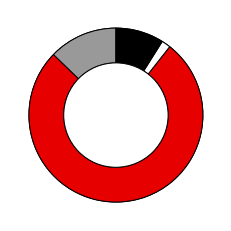

In [20]:
# Figure 1: Discrepancy between observed eruptions and estimated subaerial lava production on Earth

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

import matplotlib.pyplot as plt

for which_figure in range(1,3):
    
    # which figure?
    # 1 = eruption database from Byrne & Krishnamoorthy (2022)
    # 2 = lava production from Crisp 1984
    
    if   (which_figure == 1):
        # data from database as calculated above 
        pie_data              = [ amount_subduction_zone_eruptions, amount_rift_zone_eruptions, amount_continental_intraplate_eruptions, amount_oceanic_intraplate_eruptions ]
        start_angle_pie_chart = 90
        n                     = sum(pie_data)
        print('n = ',n,'  eruptions')
    elif (which_figure == 2):
        # data from Table 7 from Crisp (1984) using only the volcanism values like Siebert et al. (2011)
        subduction_zone_volcanism    = (0.4 + 0.6)/2
        intracontinental_volcanism   = (0.03 + 0.1)/2
        oceanic_intraplate_volcanism = (0.3 + 0.4)/2
        oceanic_ridge_volcanism      = 3
    
        pie_data              = [subduction_zone_volcanism, oceanic_ridge_volcanism, intracontinental_volcanism, oceanic_intraplate_volcanism ]
        start_angle_pie_chart = 90
        n                     = sum(pie_data)
        print('n = ',n,' km3/year')
    
    # Create pie plot
    plt.pie(pie_data, colors=[ [0.6, 0.6, 0.6], [0.9, 0, 0], [1, 1, 1], [0, 0, 0]], wedgeprops= {"edgecolor" : "black",
                          'linewidth': 1,
                          'antialiased': True}, startangle = start_angle_pie_chart )

    # add a circle at the center to transform it to a donut chart
    my_circle=plt.Circle( (0,0), 0.6, facecolor='white', edgecolor='black', linewidth=1)
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    if   (which_figure == 1):
        plt.savefig("eruptions.png",       dpi=1200)
    elif (which_figure == 2):
        plt.savefig("lava_production.png", dpi=1200)

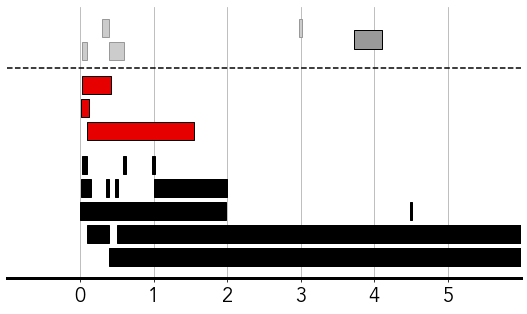

In [21]:
# Figure 2: 

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

import matplotlib.pyplot as plt
import numpy as np

number_of_Venus_estimates = 12

y_axis_Venus         = np.zeros(number_of_Venus_estimates) 
width_estimate_Venus = np.zeros(number_of_Venus_estimates)
start_estimate_Venus = np.zeros(number_of_Venus_estimates)

number_of_Earth_estimates = 5

y_axis_Earth         = np.zeros(number_of_Earth_estimates) 
width_estimate_Earth = np.zeros(number_of_Earth_estimates)
start_estimate_Earth = np.zeros(number_of_Earth_estimates)

number_of_BK_estimates = 3

y_axis_BK         = np.zeros(number_of_BK_estimates) 
width_estimate_BK = np.zeros(number_of_BK_estimates)
start_estimate_BK = np.zeros(number_of_BK_estimates)

# make Venus data for the figure 

buffer = 0.02

for i in range(0,number_of_Venus_estimates):
    if (i == 0):
        # Fegley & Prinn 1989 - rate depending on the sulphur content of the erupted material 
        y_axis_Venus[i] = 1 + i * 0.25
        start_estimate_Venus[i] = 0.4
        width_estimate_Venus[i] = 11 - start_estimate_Venus[i]
    elif (i == 1): 
        # Grimm & Solomon 1987 --> "a mean volcanic flux no greater than 2 km³/y"
        y_axis_Venus[i] = 1 + 2 * 0.25
        start_estimate_Venus[i] = 0
        width_estimate_Venus[i] = 1.99 - start_estimate_Venus[i]
    elif (i == 2):
        # Fegley & Prinn 1989 - rate depending on Venus' surface composition 
        y_axis_Venus[i] = 1 + 4 * 0.25
        start_estimate_Venus[i] = 1 - buffer
        width_estimate_Venus[i] = 2 * buffer
    elif (i == 3):
        # Strom et al 1994 
        y_axis_Venus[i] = 1 + 3 * 0.25
        start_estimate_Venus[i] = 0.01
        width_estimate_Venus[i] = 0.15 - start_estimate_Venus[i]
    elif (i == 4):
        # Bullock et al 1993
        y_axis_Venus[i] = 1 + 3 * 0.25
        start_estimate_Venus[i] = 0.37 - buffer
        width_estimate_Venus[i] = 2 * buffer
    elif (i == 5):
        # Head et al 1992 
        y_axis_Venus[i] = 1 + 3 * 0.25
        start_estimate_Venus[i] = 0.5 - buffer
        width_estimate_Venus[i] = 2 * buffer
    elif (i == 6):
        # Ivanov & Head 2013 - for intraplate volcanism on Venus 
        y_axis_Venus[i] = 1 + 4 * 0.25
        start_estimate_Venus[i] = 0.03
        width_estimate_Venus[i] = 0.09 - start_estimate_Venus[i]
    elif (i == 7):
        # McGovern & Solomon 1997 
        y_axis_Venus[i] = 1 + 1 * 0.25
        start_estimate_Venus[i] = 0.1
        width_estimate_Venus[i] = 0.4 - start_estimate_Venus[i]
    elif (i == 8):
        # Stofan et al 2005 assuming a timescale of emplacement of 750 myr
        y_axis_Venus[i] = 1 + 4 * 0.25
        start_estimate_Venus[i] = 0.6 - buffer
        width_estimate_Venus[i] = 2 * buffer
    elif (i == 9):
        # Stofan et al 2005 assuming a timescale of emplacement of 100 myr
        y_axis_Venus[i] = 1 + 2 * 0.25
        start_estimate_Venus[i] = 4.5 - buffer
        width_estimate_Venus[i] = 2 * buffer
    elif (i == 10):
        # Mian & Tozer 1990
        y_axis_Venus[i] = 1 + 3 * 0.25
        start_estimate_Venus[i] = 1
        width_estimate_Venus[i] = 2 - start_estimate_Venus[i]
    elif (i == 11):
        # Romeo & Turcotte 2010 
        y_axis_Venus[i] = 1 + 1 * 0.25
        start_estimate_Venus[i] = 0.5
        width_estimate_Venus[i] = 8.8 - start_estimate_Venus[i]
        
start_y_axis_BK =  max(y_axis_Venus) + 0.25 + 0.25/2
# make data with the estimates based on Byrne & Krishnamoorthy 2022 (i.e., results from this comment) for the figure 
for i in range(0,number_of_BK_estimates):
    y_axis_BK[i] = start_y_axis_BK + i * 0.25
    if (i == 0):
        # Byrne & Krishnamoorthy (2022) scaled for rifting volcanism  
        start_estimate_BK[i] = BK2022_rifting_min_flux
        width_estimate_BK[i] = BK2022_rifting_max_flux - BK2022_rifting_min_flux
    elif (i == 1):
        # Byrne & Krishnamoorthy (2022) with adjusted subduction volcanism 
        start_estimate_BK[i] = Venus_less_subduction_min_flux
        width_estimate_BK[i] = Venus_less_subduction_max_flux - Venus_less_subduction_min_flux
    elif (i == 2): 
        # Byrne & Krishnamoorthy (2022) corrected values 
        start_estimate_BK[i] = BK2022_min_flux
        width_estimate_BK[i] = BK2022_max_flux - BK2022_min_flux
        
start_y_axis_Earth =  max(y_axis_BK) + 0.25 + 0.25/2
# make Earth data for the figure 
for i in range(0,number_of_Earth_estimates):
    if (i == 0):
        # Crisp 1984 - subduction zones 
        y_axis_Earth[i]         = start_y_axis_Earth
        start_estimate_Earth[i] = 0.4
        width_estimate_Earth[i] = 0.6 - start_estimate_Earth[i]
    elif (i == 1):
        # Crisp 1984 - intracontinental volcanism  
        y_axis_Earth[i]         = start_y_axis_Earth
        start_estimate_Earth[i] = 0.03
        width_estimate_Earth[i] = 0.1 - start_estimate_Earth[i]
    elif (i == 2):
        # Crisp 1984 - oceanic ridge volcanism   
        y_axis_Earth[i]         = start_y_axis_Earth + 0.25
        start_estimate_Earth[i] = 3 - buffer
        width_estimate_Earth[i] = 2 * buffer
    elif (i == 3):
        # Crisp 1984 - oceanic intraplate volcanism
        y_axis_Earth[i]         = start_y_axis_Earth + 0.25 
        start_estimate_Earth[i] = 0.3
        width_estimate_Earth[i] = 0.4 - start_estimate_Earth[i]
    elif (i == 4):
        # Crisp 1984 - total 
        y_axis_Earth[i]         = start_y_axis_Earth + 0.25/2 
        start_estimate_Earth[i] = 0.4 + 0.03 + 3 + 0.3 
        width_estimate_Earth[i] = 0.6 + 0.1  + 3 + 0.4 - start_estimate_Earth[i]
    #elif (i == 5): 
    #    # Strom et al 1994 - intraplate volcanism on Earth 
    #    y_axis_Earth[i]         = start_y_axis_Earth + 0.25
    #    start_estimate_Earth[i] = 0.33 
    #    width_estimate_Earth[i] = 0.5 - start_estimate_Earth[i]
        
        
# make figure

font = {'family' : 'avenir',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(9.2, 5))

ax.grid(axis = 'x')
ax.set_axisbelow(True)

ax.barh(y_axis_Venus, width_estimate_Venus, height=0.2, left=start_estimate_Venus, align='center', facecolor=[0, 0, 0],   edgecolor=[0, 0, 0])

ax.barh(y_axis_BK, width_estimate_BK, height=0.2, left=start_estimate_BK, align='center', facecolor=[0.9, 0, 0],   edgecolor=[0, 0, 0])

plt.axhline(y=max(y_axis_BK) + 0.1875, color='k', linestyle='--')

ax.barh(y_axis_Earth, width_estimate_Earth, height=0.2, left=start_estimate_Earth, align='center', facecolor=[0.8, 0.8, 0.8],   edgecolor=[0.6, 0.6, 0.6])

ax.barh(y_axis_Earth[4], width_estimate_Earth[4], height=0.2, left=start_estimate_Earth[4], align='center', facecolor=[0.6, 0.6, 0.6],   edgecolor=[0, 0, 0])



ax.yaxis.set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.spines['bottom'].set_linewidth(3)

ax.set_xlim(-0.99,5.99)

plt.savefig("volcanic_flux.png",       dpi=1200)